In [18]:
import numpy as np
import scipy.stats as stats

In [19]:
def is_log_concave(f, x_range):
    """
    Check if the function f is log-concave over the x_range.
    
    Args:
        f(function): Probability density function (maybe unnormalized)
        x_range(array_like): Range of x values to check
    
    Returns: 
        bool: Whether the function f is concave or not.
    """
    x = np.asarray(x_range)
    f_values = f(x)
    
    if np.any(f_values <= 0):
        raise ValueError("Function values must be positive.")
    
    f_prime = np.gradient(f_values, x)
    log_deriv = f_prime / f_values
    is_descending = np.all(np.diff(log_deriv) <= 0)
    
    return is_descending

In [20]:
def construct_envelope(hull_points, h, domain):
    """
    Construct the envelope function (upper bound) from hull points.
    
    Args:
        hull_points(array-like): x-values where tangents are constructed.
        h: the log of sampling function.
        domain(tuple): (x_min, x_max), the domain boundaries of the distribution.
    
    Returns:
        pieces(list of tuples): List of (slope, intercept) for each segment.
        z_points(array_like): Start and end points of each segment.
    """
    if len(hull_points) < 3:
        raise ValueError("There must be at least 3 hull points.")
    
    x_min, x_max = domain
    h_values = h(hull_points)
    ## calculate the slopes and intercepts for each piece.
    slopes = np.gradient(h_values, hull_points)
    intercepts = h_values - hull_points * slopes
    
    ## calculate the start and end points for each piece.
    z_points = [x_min]
    for i in range(len(hull_points)-1):
        slope1, intercept1 = slopes[i], intercepts[i]
        slope2, intercept2 = slopes[i + 1], intercepts[i + 1]
        
        if np.abs(slope1 - slope2) < 1e-10:  # Avoid numerical instability
            raise ValueError("Consecutive slopes are too close; hull points must form a valid envelope.")
        z_intersect = (intercept2 - intercept1) / (slope1 - slope2)
        z_points.append(z_intersect)
    z_points.append(x_max)
    
    pieces = [(slopes[i], intercepts[i]) for i in range(len(slopes))]
    
    return pieces, z_points

def calculate_envelope(x, pieces, z_points):
    """
    Calculate the value on x for the envelope function.
    
    Args:
        x(float): the point we want to calculate.
        pieces(list of tuples): List of (slope, intercept) for each segment.
        z_points(array_like): Start and end points of each segment.
    
    Returns:
        float: value of the envelope function at x.
    """
    
    for i in range(len(pieces)):
        if x >= z_points[i] and x <= z_points[i+1]:
            slope, intercept = pieces[i]
            return intercept + slope * x

In [21]:
def construct_squeezing(hull_points, h, domain):
    """
    Construct the squeezing function (lower bound) from hull points.
    
    Args:
        hull_points(array-like): x-values where chords are constructed.
        h: the log of sampling function.
        domain(tuple): (x_min, x_max), the domain boundaries of the distribution.
    
    Returns:
        pieces(list of tuples): List of (slope, intercept) for each segment.
        z_points(array_like): Start and end points of each segment.
    """
    if len(hull_points) < 3:
        raise ValueError("There must be at least 3 hull points.")
    
    x_min, x_max = domain
    pieces = []
    z_points = [x_min, hull_points[0]]
    
    if x_min == -np.inf:
        pieces.append((0, -np.inf))
    else:
        x1, x2 = x_min, hull_points[0]
        slope = (h(x2)-h(x1))/ (x2 - x1)
        intercept = h(x1) - slope * x1
        pieces.append((slope, intercept))
    
    for i in range(len(hull_points)-1):
        x1, x2 = hull_points[i], hull_points[i+1]
        slope = (h(x2)-h(x1))/ (x2 - x1)
        intercept = h(x1) - slope * x1
        pieces.append((slope, intercept))
        z_points.append(x2)
    
    if x_max == np.inf:
        pieces.append((0, -np.inf))
    else:
        x1, x2 = hull_points[-1], x_max
        slope = (h(x2)-h(x1))/ (x2 - x1)
        intercept = h(x1) - slope * x1
        pieces.append((slope, intercept))
        
    z_points.append(x_max)
    
    return pieces, z_points

def calculate_squeezing(x, pieces, z_points):
    """
    Calculate the value on x for the squeezing function.
    
    Args:
        x(float): the point we want to calculate.
        pieces(list of tuples): List of (slope, intercept) for each segment.
        z_points(array_like): Start and end points of each segment.
    
    Returns:
        float: value of the squeezing function at x.
    """
    
    for i in range(len(pieces)):
        if x >= z_points[i] and x <= z_points[i+1]:
            slope, intercept = pieces[i]
            return intercept + slope * x

In [22]:
def sample_piecewise_linear(pieces, z_points):
    """
    Sample from the exponential of a piecewise linear function.
    
    Args:
        pieces: List of tuples (slope, intercept) representing line segments.
        z_points: List of the start and end of each piece.
    
    Returns:
        A sampled point from the exponential of piecewise linear function.
    """
    # Calculate cumulative areas under each segment
    areas = []
    cumulative_areas = [0]  # Start with 0 for cumulative sum
    for i, (slope, intercept) in enumerate(pieces):
        x_start, x_end = z_points[i], z_points[i + 1]
        if slope == 0: 
            area = np.exp(intercept) * (x_end - x_start)
        else:
            # Integral of exp(intercept + slope * x) from x_start to x_end
            area = (np.exp(intercept + slope * x_end) - np.exp(intercept + slope * x_start)) / slope
        areas.append(area)
        cumulative_areas.append(cumulative_areas[-1] + area)

    total_area = cumulative_areas[-1]  # Total area under the piecewise function
    
    # Sample a uniform random value in [0, total_area] to pick a segment
    u = np.random.uniform(0, total_area)
    
    # Find the segment corresponding to the sampled area
    segment = np.searchsorted(cumulative_areas, u) - 1  # Adjust index because cumulative_areas starts with 0
    slope, intercept = pieces[segment]
    x_start, x_end = z_points[segment], z_points[segment + 1]
    
    # Sample within the chosen segment
    if slope == 0:
        # Uniform sampling for horizontal segments
        x = np.random.uniform(x_start, x_end)
    else:
        # Solve for x in the CDF of the exponential of a line
        cdf_start = np.exp(intercept + slope * x_start) / slope
        cdf_sample = cdf_start + u - cumulative_areas[segment]
        x = (np.log(cdf_sample * slope) - intercept) / slope
    
    return x

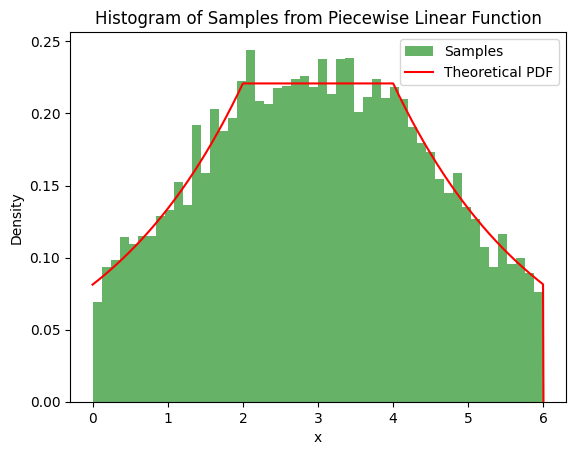

In [23]:
import matplotlib.pyplot as plt
# Test inputs for the piecewise linear function
pieces = [(0.5, 1), (0, 2), (-0.5, 4)]  # (slope, intercept)
z_points = [0, 2, 4, 6]  # x-values defining the start and end of each segment

# Sampling 10 points
samples = [sample_piecewise_linear(pieces, z_points) for _ in range(10000)]

# Plotting the histogram of sampled points
plt.hist(samples, bins=50, density=True, alpha=0.6, color='g', label='Samples')
plt.title('Histogram of Samples from Piecewise Linear Function')
plt.xlabel('x')
plt.ylabel('Density')

# Plot the theoretical exponential of piecewise linear function
x_vals = np.linspace(0, 6, 1000)
y_vals = np.zeros_like(x_vals)

for i, (slope, intercept) in enumerate(pieces):
    mask = (x_vals >= z_points[i]) & (x_vals < z_points[i + 1])
    y_vals[mask] = np.exp(intercept + slope * x_vals[mask])

area = 4 * (np.exp(2) - np.exp(1)) + 2 * np.exp(2)
plt.plot(x_vals, y_vals / area , 'r-', label='Theoretical PDF')
plt.legend()
plt.show()

In [24]:
def adaptive_search_domain(f, start=0, step=1, threshold=1e-15, max_steps=int(1e7)):
    """
    Search the domain of the given function.
    
    Args:
    - f(function): Given function we want to search for domain of. 
    - start(float): Starting searching point.
    - step(float): Searching step.
    - threshold(float): Threshold to judge whether the function value is too small
    - max_steps(int): maximum searching steps.
    
    Returns:
    - domain_start, domain_end(float): The searching domain of the function.
    """
    
    x = start
    domain_points = []
    
    # Searching towards the positive side
    for _ in range(max_steps):
        if f(x) > threshold:
            domain_points.append(x)
        x += step
    
    x = start
    
    # Searching towards the negative side
    for _ in range(max_steps):
        if f(x) > threshold:
            domain_points.append(x)
        else:
            break
        x -= step
    
    if not domain_points:
        return None
    return min(domain_points), max(domain_points)

# 示例：高斯函数
f = lambda x: np.exp(-x**2)
domain = adaptive_search_domain(f)
print(f"Adaptive searching domain: {domain}")
domain[0]

Adaptive searching domain: (-5, 5)


-5

In [25]:
def init_points(f, domain, threshold = 1e-5):
    """
    Search the initial point of the .
    
    Args:
    - f(function): Given function. 
    - domain(tuple): domain of the function.
    - threshold(float): Threshold to judge whether to be the initial point.
    
    Returns:
    - init_1, init_2(tuple): Two initial points.
    """
    
    domain_min, domain_max = adaptive_search_domain(f)
    step = (domain_max - domain_min) / 1000
    
    init_1 = domain_min
    while f(init_1) <= threshold:
        init_1 += step
    
    init_2 = domain_max
    while f(init_2) <= threshold:
        init_2 -= step
        
    return init_1, init_2  

f = lambda x: np.exp(-x**2)
domain = adaptive_search_domain(f)
init = init_points(f, domain)
print(init)

(-3.3900000000000343, 3.3900000000000343)


In [26]:
def ars_init_domain(f, num_samples, x_init, domain=(-10,10), burn_in = 10000):
    """
    Adaptive Rejection Sampling given domain and initial points.
    
    Args:
        f(function): Probability density function (maybe unnormalized)
        num_samples(int): Number of samples to generate
        x_init(array_like): Initial points to start the algorithm
        domain(tuple): (x_min, x_max), range of the distribution
        
    Returns:
        samples(array_like): num_samples number of samples from f.
    """
    
    if not is_log_concave(f, np.linspace(*domain, 1000)):
        raise ValueError("The input function is not log-concave!")

    h = lambda x: np.log(f(x))
    x_points = np.array(sorted(x_init))
    samples = []

    while len(samples)<= (num_samples + burn_in):
        # Calculate tangents and chords
        envelope_pieces, envelope_points = construct_envelope(x_points, h, domain)
        squeezing_pieces, squeezing_points = construct_squeezing(x_points, h, domain)

        # Sample from envelope
        x_star = sample_piecewise_linear(envelope_pieces, envelope_points)

        # Accept/reject
        u = np.random.uniform()
        if u <= np.exp(calculate_squeezing(x_star, squeezing_pieces, squeezing_points) - calculate_envelope(x_star, envelope_pieces, envelope_points)):  # Check lower bound
            samples.append(x_star)
        elif u <= np.exp(h(x_star) - calculate_envelope(x_star, envelope_pieces, envelope_points)):  # Accept
            samples.append(x_star)
            x_points = np.sort(np.append(x_points, x_star))
        else:
            x_points = np.sort(np.append(x_points, x_star))
            
    samples = samples[burn_in+1:]
    return np.array(samples), x_points

71


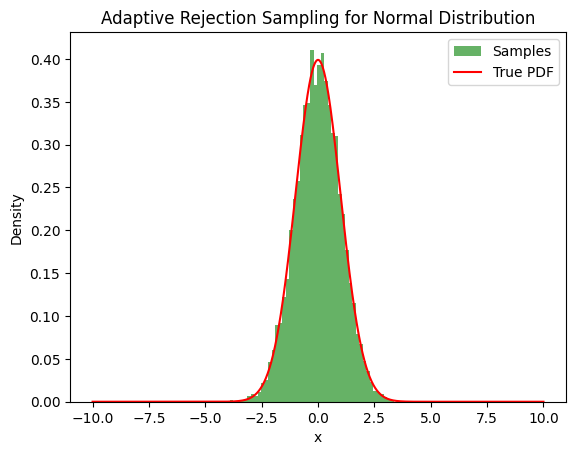

In [27]:
import numpy as np
import matplotlib.pyplot as plt

# Example: Normal distribution (log-concave)
def f(x):
    return np.exp(-0.5 * x**2)  # Normal distribution

# Test the ARS function
num_samples = 10000
x_init = np.linspace(-5, 5, 10)  # Initial hull points

samples, x_points = ars_init_domain(f, num_samples, x_init)

print(len(x_points))
# Plot the results
plt.hist(samples, bins=50, density=True, alpha=0.6, color='g', label='Samples')

# Plot the true PDF for comparison
x_vals = np.linspace(-10, 10, 1000)
y_vals = np.exp(-0.5 * x_vals**2)/np.sqrt(2 * np.pi)  # Normalized PDF
plt.plot(x_vals, y_vals, 'r-', label='True PDF')

plt.legend()
plt.title("Adaptive Rejection Sampling for Normal Distribution")
plt.xlabel("x")
plt.ylabel("Density")
plt.show()

In [28]:
def ars(f, num_samples):
    domain = adaptive_search_domain(f)
    init_1, init_2 = init_points(f, domain)
    x_init = np.linspace(init_1, init_2, 10)
    samples, x_points = ars_init_domain(f, num_samples, x_init = x_init, domain = domain)
    return samples, x_points   

1000
[ 95.216       96.27911111  96.89623024  97.11295942  97.34222222
  97.55713257  97.91071455  98.05513904  98.14513642  98.21538529
  98.32476371  98.40533333  98.44951346  98.46445882  98.58193103
  98.69433148  98.88666769  99.01593004  99.11288115  99.15307686
  99.2025413   99.26307853  99.30980429  99.39791825  99.46844444
  99.55660555  99.60794243  99.72178271  99.75379135  99.80366763
  99.87367447  99.95246961 100.06218    100.11063411 100.19478676
 100.24588645 100.32570172 100.39965838 100.48656943 100.53155556
 100.63360812 100.71640143 100.73803043 100.82416687 100.87805313
 100.92906507 101.11799098 101.15548763 101.2753981  101.31449175
 101.32456913 101.45180216 101.59466667 101.73230365 101.76459333
 101.96110519 102.11398803 102.19743415 102.23122638 102.32937572
 102.38483726 102.65777778 102.75034668 102.96680767 103.72088889
 104.784     ]


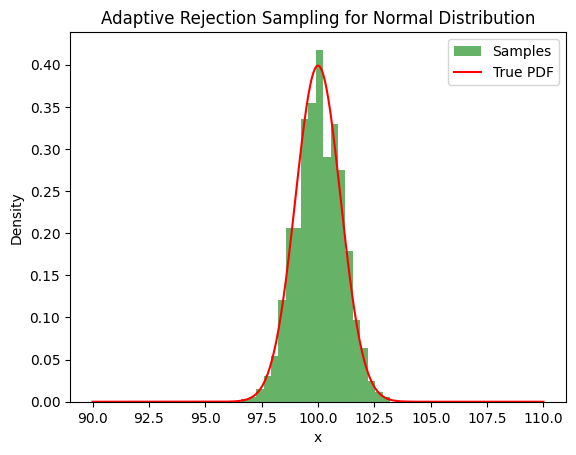

In [29]:
import numpy as np
import matplotlib.pyplot as plt

# Example: Normal distribution (log-concave)
def f(x):
    return np.exp(-0.5 * (x-100)**2)  # Normal distribution

# Test the ARS function
num_samples = 1000

samples, x_points = ars(f, num_samples)
print(len(samples))
print(x_points)
# Plot the results
plt.hist(samples, bins=20, density=True, alpha=0.6, color='g', label='Samples')

# Plot the true PDF for comparison
x_vals = np.linspace(90, 110, 1000)
y_vals = np.exp(-0.5 * (x_vals-100)**2)/np.sqrt(2 * np.pi)  # Normalized PDF
plt.plot(x_vals, y_vals, 'r-', label='True PDF')

plt.legend()
plt.title("Adaptive Rejection Sampling for Normal Distribution")
plt.xlabel("x")
plt.ylabel("Density")
plt.show()

In [15]:
import numpy as np
from ars.utils import check_overflow_underflow, h_log, h_cached
from ars.validation import is_log_concave

def construct_envelope(hull_points, h, domain):
    x_min, x_max = domain
    h_values = h(hull_points)

    slopes = np.gradient(h_values, hull_points)
    intercepts = h_values - hull_points * slopes

    z_points = [x_min]
    for i in range(len(hull_points) - 1):
        slope1, intercept1 = slopes[i], intercepts[i]
        slope2, intercept2 = slopes[i + 1], intercepts[i + 1]

        if np.abs(slope1 - slope2) < 1e-10:  # Avoid numerical instability
            raise ValueError("Consecutive slopes are too close; invalid envelope.")
        z_intersect = (intercept2 - intercept1) / (slope1 - slope2)
        z_points.append(z_intersect)

    z_points.append(x_max)
    pieces = [(float(slopes[i]), float(intercepts[i])) for i in range(len(slopes))]
    return pieces, z_points

def calculate_envelope(x, pieces, z_points):
    
    for i in range(len(pieces)):
        if z_points[i] <= x <= z_points[i + 1]:
            slope, intercept = pieces[i]
            return i, intercept + slope * x

def construct_squeezing(hull_points, h, domain):
    """
    Construct the squeezing function (lower bound) from hull points.
    
    Args:
        hull_points(array-like): x-values where chords are constructed.
        h: the log of sampling function.
        domain(tuple): (x_min, x_max), the domain boundaries of the distribution.
    
    Returns:
        pieces(list of tuples): List of (slope, intercept) for each segment.
        z_points(array_like): Start and end points of each segment.
    """
    if len(hull_points) < 3:
        raise ValueError("There must be at least 3 hull points.")
    
    x_min, x_max = domain
    pieces = []
    z_points = [x_min, hull_points[0]]
    
    if x_min == -np.inf:
        pieces.append((0, -np.inf))
    else:
        x1, x2 = x_min, hull_points[0]
        slope = (h(x2)-h(x1))/ (x2 - x1)
        intercept = h(x1) - slope * x1
        pieces.append((slope, intercept))
    
    for i in range(len(hull_points)-1):
        x1, x2 = hull_points[i], hull_points[i+1]
        slope = (h(x2)-h(x1))/ (x2 - x1)
        intercept = h(x1) - slope * x1
        pieces.append((slope, intercept))
        z_points.append(x2)
    
    if x_max == np.inf:
        pieces.append((0, -np.inf))
    else:
        x1, x2 = hull_points[-1], x_max
        slope = (h(x2)-h(x1))/ (x2 - x1)
        intercept = h(x1) - slope * x1
        pieces.append((slope, intercept))
        
    z_points.append(x_max)
    
    return pieces, z_points

def calculate_squeezing(x, pieces, z_points):
    """
    Calculate the value on x for the squeezing function.
    
    Args:
        x(float): the point we want to calculate.
        pieces(list of tuples): List of (slope, intercept) for each segment.
        z_points(array_like): Start and end points of each segment.
    
    Returns:
        float: value of the squeezing function at x.
    """
    
    for i in range(len(pieces)):
        if x >= z_points[i] and x <= z_points[i+1]:
            slope, intercept = pieces[i]
            return intercept + slope * x

In [ ]:
def update_envelope(x_points, new_point, h, slopes, intercepts, z_points, domain):
    # Insert the new point into the sorted list of x_points
    x_points = np.sort(np.append(x_points, new_point))

    # Update slopes and intercepts based on the new point
    slopes = []
    intercepts = []
    for idx in range(1, len(x_points)):
        slopes.append((h(x_points[idx]) - h(x_points[idx - 1])) / (x_points[idx] - x_points[idx - 1]))
        intercepts.append(h(x_points[idx]) - slopes[-1] * x_points[idx])

    # Update z_points to reflect the new x_points and corresponding function values
    z_points = np.array([h(x) for x in x_points])  # This ensures z_points has length len(x_points)

    # Ensure the lengths of pieces and z_points are aligned
    pieces = list(zip(slopes, intercepts))

    # Print debug info for checking
    print(f"DEBUG: Updated Envelope - z_points length: {len(z_points)}, pieces length: {len(pieces)}")

    return x_points, slopes, intercepts, z_points

def update_picewise_linear(pieces, z_points, new_point, loc):

In [ ]:
def sample_piecewise_linear(pieces, z_points):
    # Input checks
    if len(z_points) != len(pieces) + 1:
        raise ValueError(f"Length of `z_points` ({len(z_points)}) should be length of `pieces` ({len(pieces)}) + 1")

    areas, cumulative_areas = [], [0]
    
    for i, (slope, intercept) in enumerate(pieces):
        x_start, x_end = z_points[i], z_points[i + 1]
        if slope == 0:
            area = np.exp(intercept) * (x_end - x_start)
        else:
            # Overflow protection
            log_start = intercept + slope * x_start
            log_end = intercept + slope * x_end
            log_start, log_end = check_overflow_underflow([log_start, log_end])
            area = (np.exp(log_end) - np.exp(log_start)) / slope
        areas.append(area)
        cumulative_areas.append(cumulative_areas[-1] + area)

    total_area = cumulative_areas[-1]
    u = np.random.uniform(0, total_area)
    segment = np.searchsorted(cumulative_areas, u) - 1
    slope, intercept = pieces[segment]
    x_start, x_end = z_points[segment], z_points[segment + 1]

    if slope == 0:
        return np.random.uniform(x_start, x_end)
    else:
        cdf_start = np.exp(np.clip(intercept + slope * x_start, -700, 700)) / slope
        cdf_sample = cdf_start + u - cumulative_areas[segment]
        return (np.log(cdf_sample * slope) - intercept) / slope

In [ ]:
def adaptive_search_domain(f, start=0, step=1, threshold=1e-15, max_steps=int(1e7)):
    """
    Search the domain of the given function.
    
    Args:
    - f(function): Given function we want to search for domain of. 
    - start(float): Starting searching point.
    - step(float): Searching step.
    - threshold(float): Threshold to judge whether the function value is too small
    - max_steps(int): maximum searching steps.
    
    Returns:
    - domain_start, domain_end(float): The searching domain of the function.
    """
    
    x = start
    domain_points = []
    
    # Searching towards the positive side
    for _ in range(max_steps):
        if f(x) > threshold:
            domain_points.append(x)
        x += step
    
    x = start
    
    # Searching towards the negative side
    for _ in range(max_steps):
        if f(x) > threshold:
            domain_points.append(x)
        else:
            break
        x -= step
    
    if not domain_points:
        return None
    return min(domain_points), max(domain_points)

def init_points(f, domain, threshold = 1e-5):
    """
    Search the initial point of the .
    
    Args:
    - f(function): Given function. 
    - domain(tuple): domain of the function.
    - threshold(float): Threshold to judge whether to be the initial point.
    
    Returns:
    - init_1, init_2(tuple): Two initial points.
    """
    
    domain_min, domain_max = adaptive_search_domain(f)
    step = (domain_max - domain_min) / 1000
    
    init_1 = domain_min
    while f(init_1) <= threshold:
        init_1 += step
    
    init_2 = domain_max
    while f(init_2) <= threshold:
        init_2 -= step
        
    return init_1, init_2

def ars(f, num_samples, domain = (-np.inf, np.inf), burn_in=1000, num_init_points=10):
    """
    Adaptive Rejection Sampling with intelligent initialization and overflow protection.

    Args:
        f (function): Target probability density function.
        num_samples (int): Number of samples to generate.
        domain (tuple): Range of the distribution.
        burn_in (int): Number of initial samples to discard.
        num_init_points (int): Number of initial points for constructing envelope.

    Returns:
        np.array: Array of sampled points.
    """
    print("Starting ARS ...")
    print("Checking if the function is log-concave ...")
    domain = adaptive_search_domain(f)
    print(domain)
    if not is_log_concave(f, np.linspace(*domain, 1000), eps =1e-17):
        raise ValueError("The input function is not log-concave!")

    h = lambda x: h_log(f, x)
    
    init_1, init_2 = init_points(f, domain)
    x_points = np.linspace(init_1, init_2, num_init_points)
    
    samples = []
    envelope_pieces, envelope_z_points = construct_envelope(x_points, h, domain)
    squeezing_pieces, squeezing_z_points = construct_squeezing(x_points, h, domain)
    iteration = 0

    while len(samples) <= (num_samples + burn_in):
        # Sample from the envelope
        x_star = sample_piecewise_linear(pieces, z_points)
        u = np.random.uniform()
        print(f"DEBUG: Iteration {iteration}, x_star={x_star}, u={u}")

        # Check acceptance criteria
        if u <= np.exp(calculate_squeezing(x_star, squeezing_pieces, squeezing_points) - calculate_envelope(x_star, envelope_pieces, envelope_points)):  # Check lower bound
            samples.append(x_star)
            print(f"DEBUG:      Accepted x_star={x_star}")
        elif u <= np.exp(h_cached(f, x_star) - calculate_envelope(x_star, envelope_pieces, envelope_points)):
            samples.append(x_star)
            print(f"DEBUG:      Accepted x_star={x_star}")
            
            
        else:
            print(f"DEBUG: Rejected x_star={x_star}")
            slopes = list(slopes)  # Convert slopes to list (if tuple)
            intercepts = list(intercepts)  # Convert intercepts to list (if tuple)
            z_points = list(z_points)

            # Incrementally update the envelope with the new point
            x_points, slopes, intercepts, z_points = update_envelope(
                x_points, x_star, h, slopes, intercepts, z_points, domain
            )
            pieces = list(zip(slopes, intercepts))
        iteration += 1

    print(f"Finished sampling. Total samples collected: {len(samples)}")
    return np.array(samples)

Starting ARS ...
Checking if the function is log-concave ...
(92, 108)
DEBUG: Iteration 0, x_star=99.04241131907864, u=0.69614231933434
DEBUG:      Accepted x_star=99.04241131907864
DEBUG: Iteration 1, x_star=99.29048117642499, u=0.7413760393055853
DEBUG:      Accepted x_star=99.29048117642499
DEBUG: Iteration 2, x_star=99.31025365613698, u=0.9542804153233714
DEBUG:      Accepted x_star=99.31025365613698
DEBUG: Iteration 3, x_star=100.09903967573608, u=0.2848328811507719
DEBUG:      Accepted x_star=100.09903967573608
DEBUG: Iteration 4, x_star=100.14582987890005, u=0.4974829259671145
DEBUG:      Accepted x_star=100.14582987890005
DEBUG: Iteration 5, x_star=98.97854753646963, u=0.21142322557107218
DEBUG:      Accepted x_star=98.97854753646963
DEBUG: Iteration 6, x_star=100.03065402180532, u=0.07313758035054152
DEBUG:      Accepted x_star=100.03065402180532
DEBUG: Iteration 7, x_star=99.1972465678514, u=0.8531553346474092
DEBUG:      Accepted x_star=99.1972465678514
DEBUG: Iteration 8, x

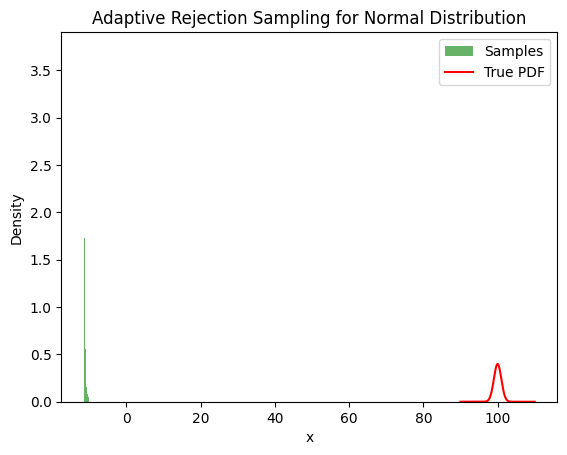

In [16]:
import numpy as np
import matplotlib.pyplot as plt

# Example: Normal distribution (log-concave)
def f(x):
    return np.exp(-0.5 * (x-100)**2)  # Normal distribution

# Test the ARS function
num_samples = 1000

samples = ars(f, num_samples)
print(len(samples))

# Plot the results
plt.hist(samples, bins=20, density=True, alpha=0.6, color='g', label='Samples')

# Plot the true PDF for comparison
x_vals = np.linspace(90, 110, 1000)
y_vals = np.exp(-0.5 * (x_vals-100)**2)/np.sqrt(2 * np.pi)  # Normalized PDF
plt.plot(x_vals, y_vals, 'r-', label='True PDF')

plt.legend()
plt.title("Adaptive Rejection Sampling for Normal Distribution")
plt.xlabel("x")
plt.ylabel("Density")
plt.show()

In [14]:
import numpy as np

def is_log_concave(f, x_range, eps=1e-17):
    """Checks if a function is log-concave over the given range."""
    x = np.asarray(x_range)
    
    if np.any(np.diff(x) <= 0): # Ensure no duplicates in range (for numerical differentiation)
        raise ValueError("x_range need to be increasing.")
    
    f_values = f(x)
    if np.any(f_values <= 0):
        raise ValueError("Function values must be positive.")
    
    f_values = np.maximum(f_values, eps)
    #f_prime = np.gradient(f_values, x)
    #log_deriv = f_prime / f_values
    #is_descending = np.all(np.diff(log_deriv) <= 0)
    
    log_f_values = np.log(f_values)
    
    # Compute second derivative
    log_f_second_derivative = np.gradient(np.gradient(log_f_values, x), x)
    
    # Check second derivative is non-positive (i.e. log-concave condition)
    is_log_concave = np.all(log_f_second_derivative <= 0)
    
    return is_log_concave


def f(x):
    return np.exp(-0.5 * x**2)  # Normal distribution

x_range = np.linspace(-8,8,1000)
is_log_concave(f, x_range)

np.True_